In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pickle as pk
import matplotlib as mpl
import json
import pandas as pd

In [2]:
city = 'London'

## Convergence

In [3]:
file = open('results/' + city + '/reward', 'rb')
reward = pk.load(file)

In [4]:
len(reward)

100

In [5]:
def plot_convergence(reward):
    mpl.rcParams['figure.dpi']= 300
    plt.rcParams["figure.figsize"] = [5, 3]
    fig, ax = plt.subplots()
    xpoints = np.array([i for i in range(1, len(reward)+1)])
    ypoints = np.array(reward)

    ax.set_title('Convergência - ' + city)
    plt.xlabel("Episodio de treinamento")
    plt.ylabel("Recompensa média")
    plt.plot(xpoints, ypoints)
    plt.savefig("results/" + city + "/plots/convergence.pdf", bbox_inches='tight')
    plt.show()

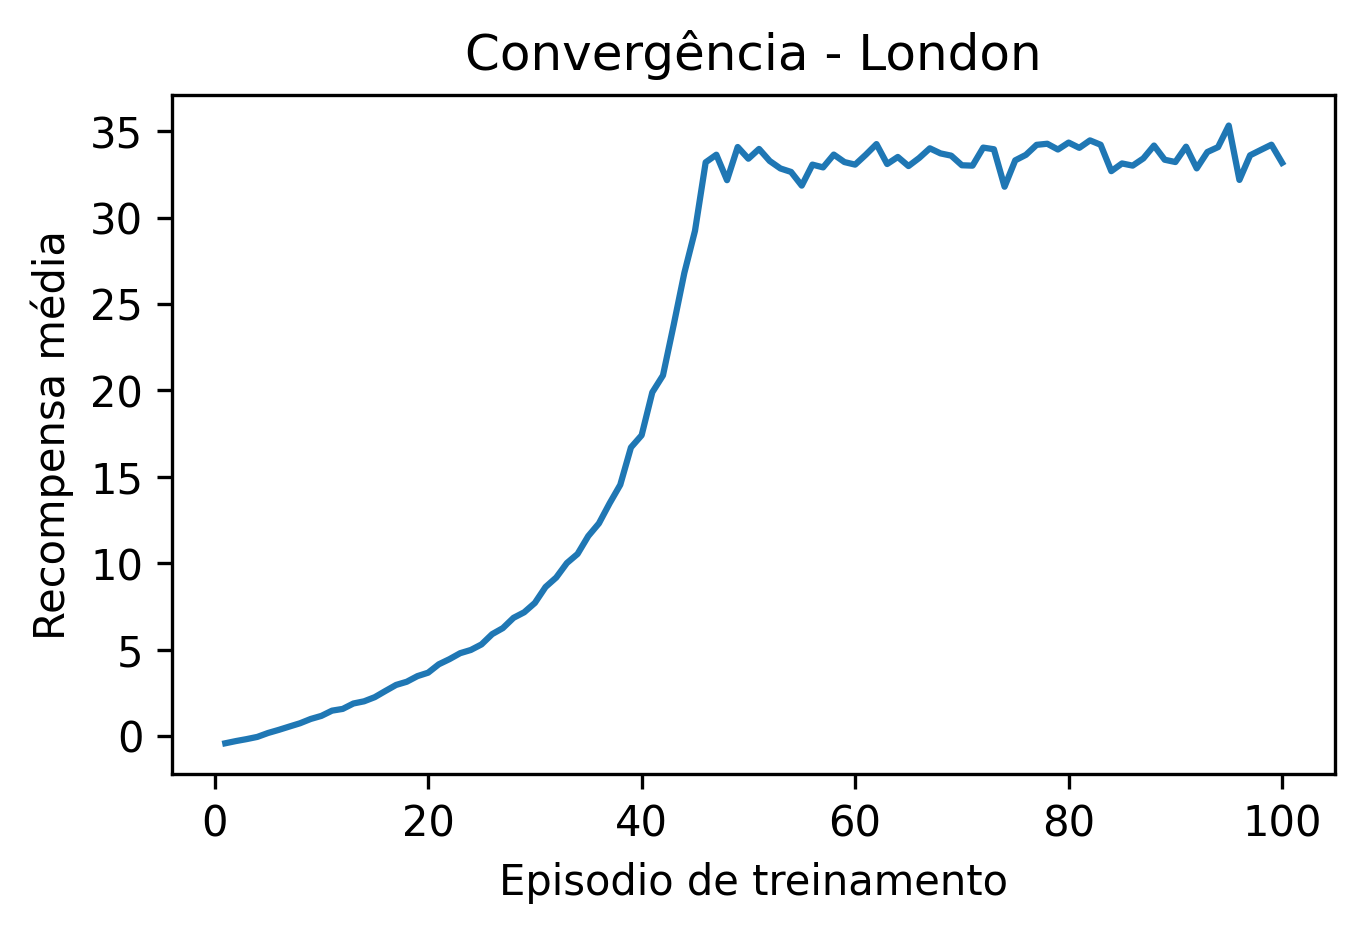

In [6]:
plot_convergence(reward)

## Recall and Precision

In [7]:
f = open('results/' + city + '/result.json')
data = json.load(f)

In [8]:
number_of_users = len(data.keys())

In [9]:
def intersection(list_a, list_b):
    return [ e for e in list_a if e in list_b ]

In [10]:
Total_R = []
Total_P = []
Mean_R = 0
Mean_P = 0
instances = 0
for item in data.keys():
    if(len(data[item]['original']) >= 2):
        recall = len(intersection(data[item]['original'], data[item]['recommendation']))/len(data[item]['original'])
        precis = len(intersection(data[item]['original'], data[item]['recommendation']))/len(data[item]['recommendation'])
        Mean_P = Mean_P + precis
        Mean_R = Mean_R + recall
        Total_R.append(recall)
        Total_P.append(precis)
        instances = instances + 1
    
Mean_P = Mean_P / instances
Mean_R = Mean_R / instances

In [11]:
def plot_cdf_recall_precision(Total_R, Total_P, Mean_R, Mean_P):
    #sns.set_theme(style="darkgrid")
    mpl.rcParams['figure.dpi']= 300

    plt.rcParams["figure.figsize"] = [5, 3]
    plt.rcParams["figure.autolayout"] = True

    data1 = Total_R
    data2 = Total_P
    
    count1, bins_count1 = np.histogram(data1, bins=100)
    pdf1 = count1 / sum(count1)
    cdf1 = np.cumsum(pdf1)
    plt.plot(bins_count1[1:], cdf1, label="CDF Recall", color='#ff4578')
    plt.plot(0.5, Mean_R, 'o', label="Recall Mean", color='#009933')
    
    count2, bins_count2 = np.histogram(data2, bins=100)
    pdf2 = count2 / sum(count2)
    cdf2 = np.cumsum(pdf2)
    plt.plot(bins_count2[1:], cdf1, label="CDF Precision", color='#111111')
    plt.plot(0.5, Mean_P, 's', label="Precision Mean", color='#009933')
    
    plt.xlabel("Metrics", fontsize=16)
    plt.ylabel("Percentage", fontsize=16)
    
    plt.yticks(fontsize=14)
    plt.xticks(fontsize=14)
    
    plt.grid(linestyle = '--')
    plt.legend()
    plt.savefig("results/" + city + "/plots/recall_precision.pdf", bbox_inches='tight')
    plt.show()

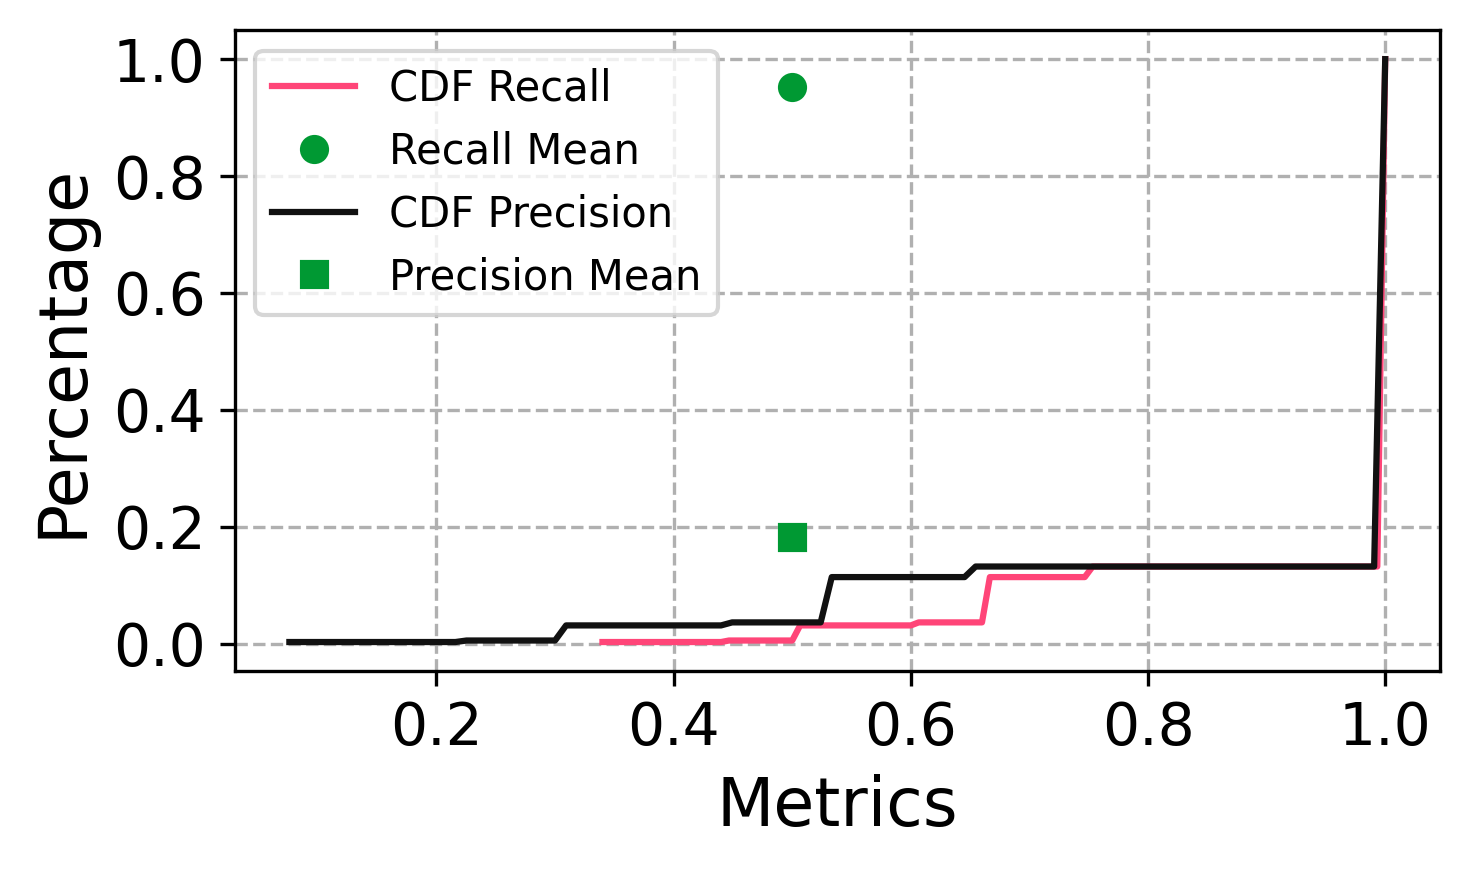

In [12]:
plot_cdf_recall_precision(Total_R, Total_P, Mean_R, Mean_P)

## NDCG

## POI Resurce Usage

In [13]:
pois = pd.read_csv("data_process/_RawData/" + city + "/POIs.csv")
quantity_of_POIS = len(pois)

POI_to_ID = {}
ID_to_POI = {}
index = 0
for poi in list(pois['poiID']):
    POI_to_ID[poi] = index
    ID_to_POI[index] = poi
    index = index + 1

In [14]:
bandwidth_temporal_usage = np.zeros(shape=(quantity_of_POIS,quantity_of_POIS))
mec_temporal_usage = np.zeros(shape=(quantity_of_POIS,quantity_of_POIS))
bandwidth_temporal_usage[:] = np.nan
mec_temporal_usage[:] = np.nan

for item in data:
    #print(item)
    t = 0
    for poi in data[item]['recommendation']:
        poi_index = POI_to_ID[poi]
        if(np.isnan(bandwidth_temporal_usage[poi_index][t])):
            bandwidth_temporal_usage[poi_index][t] = 0
            
        if(np.isnan(mec_temporal_usage[poi_index][t])):
            mec_temporal_usage[poi_index][t] = 0
        
        bandwidth_temporal_usage[poi_index][t] = bandwidth_temporal_usage[poi_index][t] + data[item]['allocated_bandwidth'][t]
        mec_temporal_usage[poi_index][t] = mec_temporal_usage[poi_index][t] + data[item]['allocated_mec'][t]
        t = t + 1

In [15]:
max_mec_usage_per_poi = []
max_bandwidth_usage_per_poi = []
for item in range(0, quantity_of_POIS):
    max_bandwidth_usage_per_poi.append(np.nanmax(bandwidth_temporal_usage[item]))
    max_mec_usage_per_poi.append(np.nanmax(mec_temporal_usage[item]))

In [16]:
def plot_max_bandwidth_usage_per_poi(pois, max_usage):

    fig = plt.figure(figsize = (5,3))

    # creating the bar plot
    plt.bar(pois, max_usage, color ='#003366',
            width = 0.8)
    
    plt.xticks([1, len(pois)])
    plt.yticks([0, 25, 50, 75])
    
    plt.xlabel("Point of Interest ID")
    plt.ylabel("Maximum bandwidth usage (Mbps)")
    #plt.title("Students enrolled in different courses")
    plt.grid(axis = 'y')
    plt.savefig("results/" + city + "/plots/bandwidth_usage.pdf", bbox_inches='tight')
    plt.show()

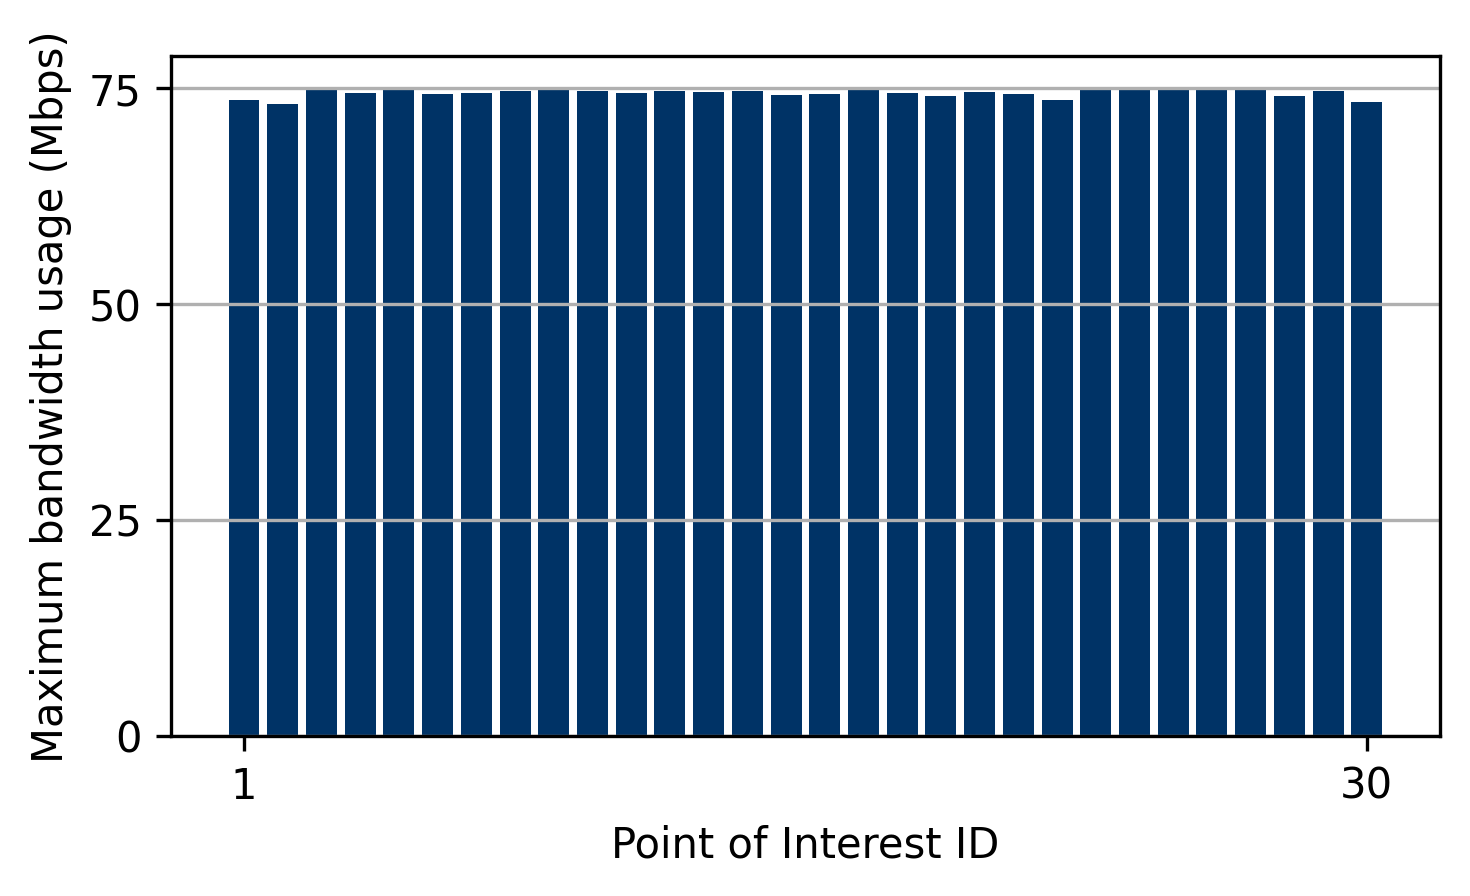

In [17]:
plot_max_bandwidth_usage_per_poi(list(pois['poiID']), max_bandwidth_usage_per_poi)

In [24]:
def plot_max_mec_usage_per_poi(pois, max_usage):

    fig = plt.figure(figsize = (5,3))

    # creating the bar plot
    plt.bar(pois, max_usage, color ='#006666',
            width = 0.8)
    
    plt.xticks([1, len(pois)])
    #plt.yticks([0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20])
    plt.yticks([0, 10, 20, 30, 40, 50, 60, 70, 75])
    
    plt.xlabel("Point of Interest ID")
    plt.ylabel("Maximum MEC usage (RCs)")
    #plt.title("Students enrolled in different courses")
    plt.grid(axis = 'y')
    plt.savefig("results/" + city + "/plots/mec_usage.pdf", bbox_inches='tight')
    plt.show()

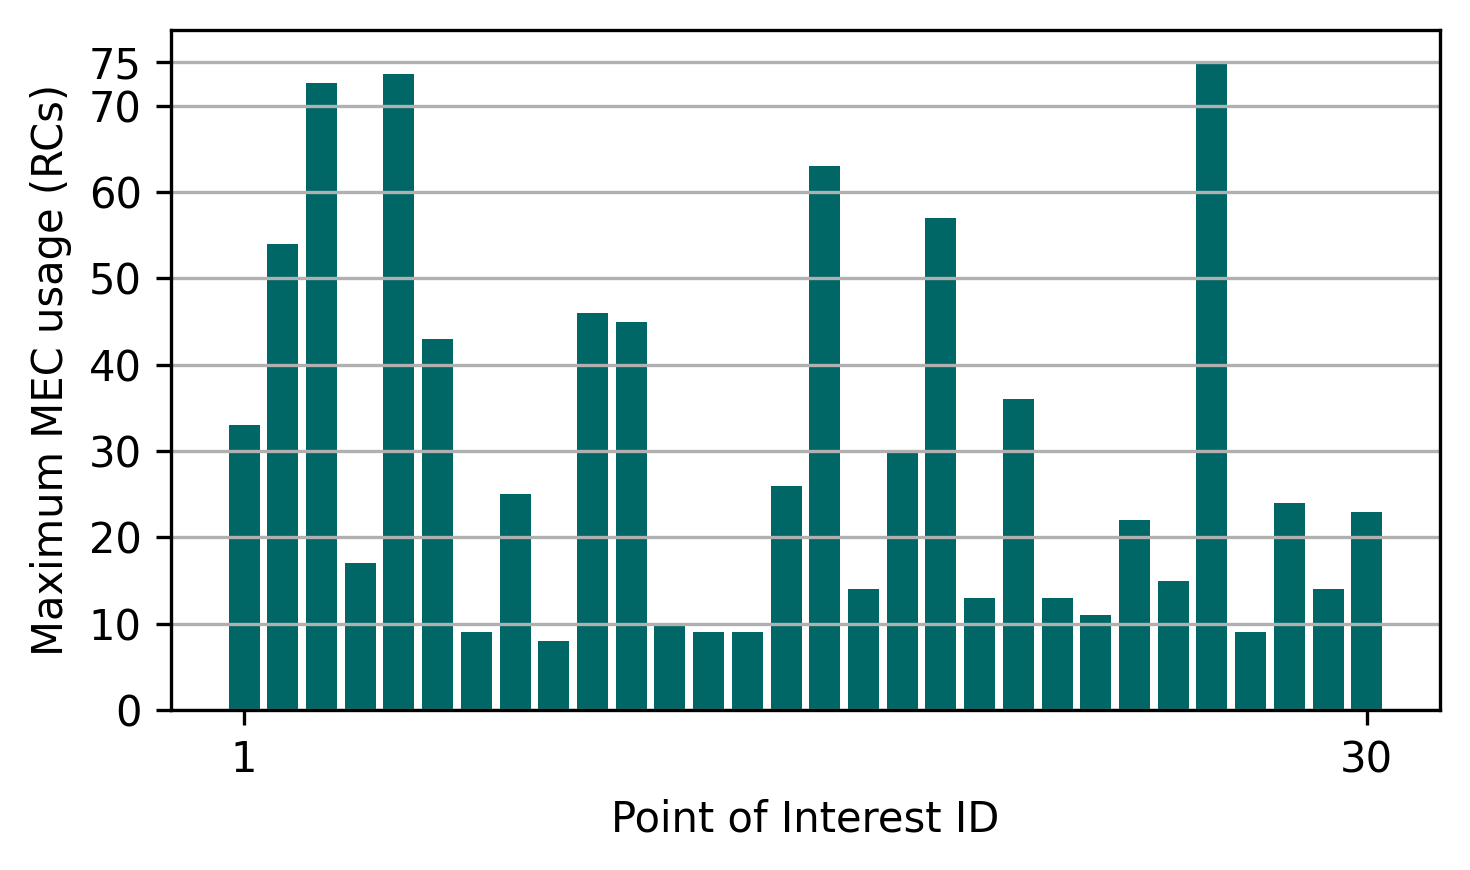

In [25]:
plot_max_mec_usage_per_poi(list(pois['poiID']), max_mec_usage_per_poi)

## User resource allocation

## Solution Time